In [1]:
import numpy as np
import tensorflow as tf
from edward.models import Normal
import edward as ed

import seaborn as sn

import matplotlib.pyplot as plt
import os  

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
M = 128  # batch size during training
d = 100  # latent dimension

data_dir = "/tmp/data"
out_dir = "/tmp"

In [3]:
from observations import mnist

def generator(array, batch_size):
    """Generate batch with respect to array's first axis."""
    start = 0  # pointer to where we are in iteration
    while True:
        stop = start + batch_size
        diff = stop - array.shape[0]
        if diff <= 0:
            batch = array[start:stop]
            start += batch_size
        else:
            batch = np.concatenate((array[start:], array[:diff]))
            start = diff
        batch = batch.astype(np.float32) / 255.0  # normalize pixel intensities
        batch = np.random.binomial(1, batch)  # binarize images
        yield batch

data_dir = 'temp0/dev/anjani/'
(x_train, _), (x_test, _) = mnist(data_dir)
x_train_generator = generator(x_train, M)
x_ph = tf.placeholder(tf.float32, [M, 784])


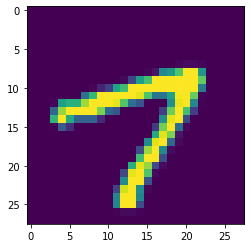

In [4]:
plt.imshow(x_train[101].reshape(28,28))

In [5]:
from edward.models import Uniform

def generative_network(eps):
    net = tf.layers.dense(eps, 100, activation=tf.nn.relu)
    net = tf.layers.dense(net, 128, activation=tf.nn.relu)
    net = tf.layers.dense(net, 784, activation=tf.sigmoid)
    return net

with tf.variable_scope("Gen"):
    eps = Uniform(tf.zeros([M, d]) - 1.0, tf.ones([M, d]))
    x = generative_network(eps)

In [6]:
def discriminative_network(x):
    """Outputs probability in logits."""
    net = tf.layers.dense(x, 100, activation=tf.nn.relu)
    net = tf.layers.dense(net, 128, activation=tf.nn.relu)
    net = tf.layers.dense(net, 1, activation=None)
    return net

In [7]:
inference = ed.GANInference(    data={x: x_ph}, discriminator=discriminative_network)

In [8]:
optimizer = tf.train.AdamOptimizer()
optimizer_d = tf.train.AdamOptimizer()

inference.initialize(    optimizer=optimizer, optimizer_d=optimizer_d,    n_iter=45000, n_print=1000)

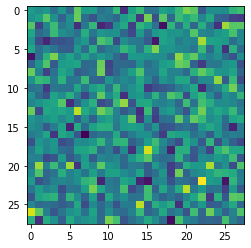

 1000/45000 [  2%]                                ETA: 357s | Gen Loss: 18.745 | Disc Loss: 0.000 

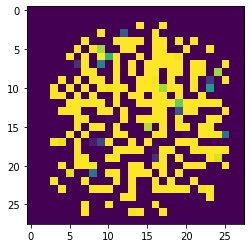

 2000/45000 [  4%] █                              ETA: 313s | Gen Loss: 16.998 | Disc Loss: 0.000

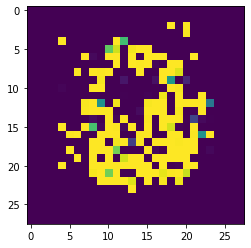

 3000/45000 [  6%] ██                             ETA: 294s | Gen Loss: 12.969 | Disc Loss: 0.000

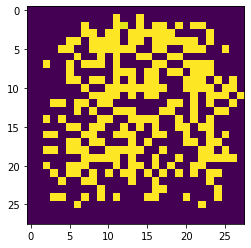

 4000/45000 [  8%] ██                             ETA: 285s | Gen Loss: 8.719 | Disc Loss: 0.000 

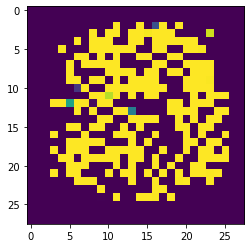

 5000/45000 [ 11%] ███                            ETA: 274s | Gen Loss: 12.756 | Disc Loss: 0.000

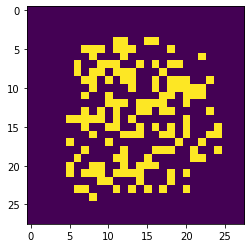

 6000/45000 [ 13%] ████                           ETA: 264s | Gen Loss: 13.787 | Disc Loss: 0.000

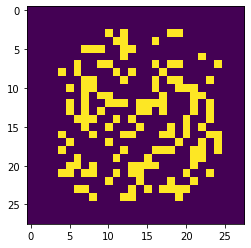

 7000/45000 [ 15%] ████                           ETA: 255s | Gen Loss: 13.531 | Disc Loss: 0.000

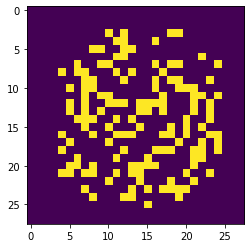

 8000/45000 [ 17%] █████                          ETA: 247s | Gen Loss: 15.032 | Disc Loss: 0.000

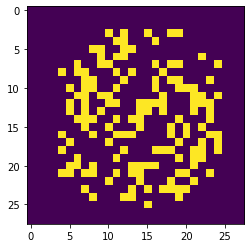

In [ ]:
sess = ed.get_session()
tf.global_variables_initializer().run()

idx = np.random.randint(M, size=16)
i = 0
for t in range(inference.n_iter):
    if t % inference.n_print == 0:
        samples = sess.run(x)
        plt.imshow(samples[1].reshape(28,28))
        plt.show()
        i += 1

    x_batch = next(x_train_generator)
    info_dict = inference.update(feed_dict={x_ph: x_batch})
    inference.print_progress(info_dict)